# Social network 3: Complex and dynamical networks using Python and networkx

In this workshop, we will focus on generating networks through code, and seeing some of the interesting and at times unexpected dynamics of networks.

We will learn how to generate network using algorithms, and how the algorithms shape the properties of these networks


In [6]:
import networkx as nx
from matplotlib import pyplot as plt
import random
from collections import Counter

# 1. Small world simulation

In this exercise, we will start with a geographical network, in which each node is connected to their four closest neighbhors, in a big circle.

We will then see how the average shortest path depends on the number of edges we randomize in this network.

The aim of this exercise is to see how nearly universal the small-world phenomenon is. 

In [3]:
# Circle network
import networkx as nx
from matplotlib import pyplot as plt

def create_circle_network(num_nodes=1000):
    # This is code creates a simple circular network, were each node is connected to their neighbors 
    # Create an empty graph
    G = nx.Graph()
    
    # Add nodes and edges to create a circular network
    for i in range(num_nodes):
        G.add_node(i)
        G.add_edge(i, (i + 1) % num_nodes)  # Connect each node to its neighbor, using modulo for circular connection
        G.add_edge(i, (i + 2) % num_nodes)  # Connect each node to its second neighbor, using modulo for circular connection
    
    # Draw the network
    nx.draw_circular(G, with_labels=True, node_color='lightblue', node_size=20, font_size=5)
    plt.title(f"Random Network with {num_nodes} Nodes")
    plt.show()
    return G

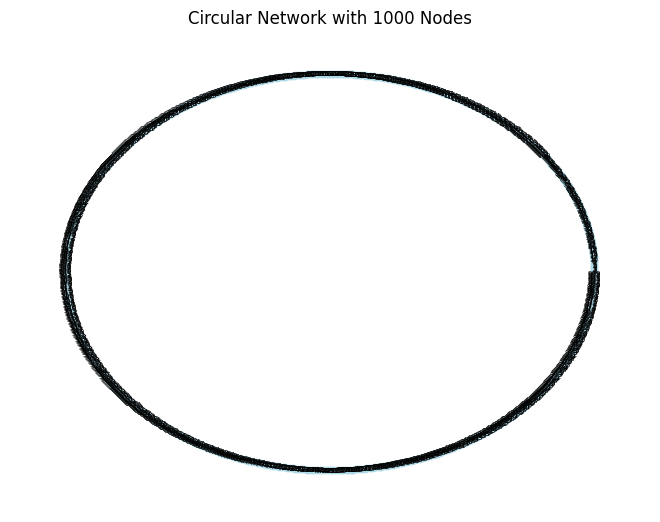

The average shortest path between two nodes in this network is 125.37537537537537


In [50]:
G = create_circle_network()
print(f'The average shortest path between two nodes in this network is {nx.average_shortest_path_length(G)}')

### Question:
Your task is to answer: *What fraction of edges would you need to replace with random edges for the average shortest path to drop to 1/10 of this value* (i.e. 12.5)? Write code to replace the edges one by one by a random edge. For each edge removed, measure the new average shortest path. Plot the average shortest path as a function of the fraction of edges that are randomized. How do you interpret your finding? 


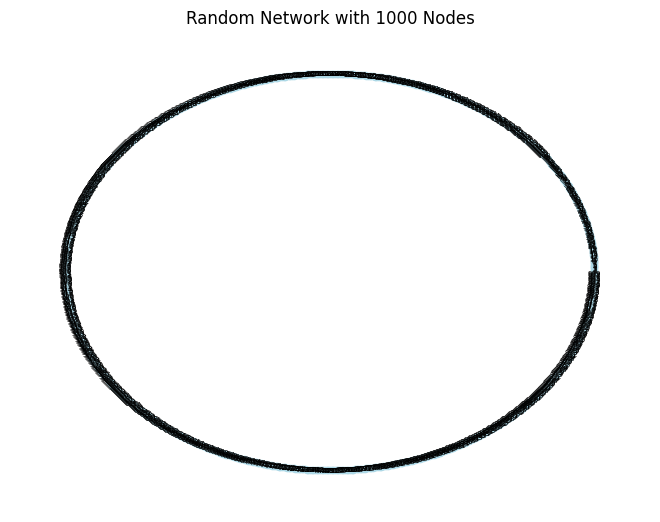

The network became 10 times smaller after replacing 4.65% of the edges.


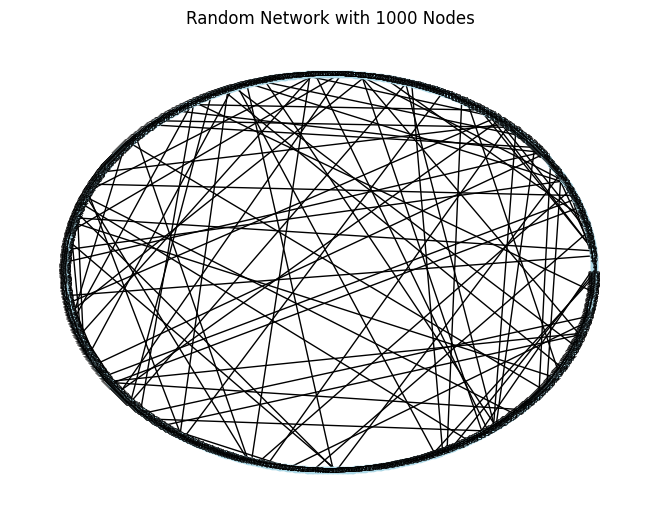

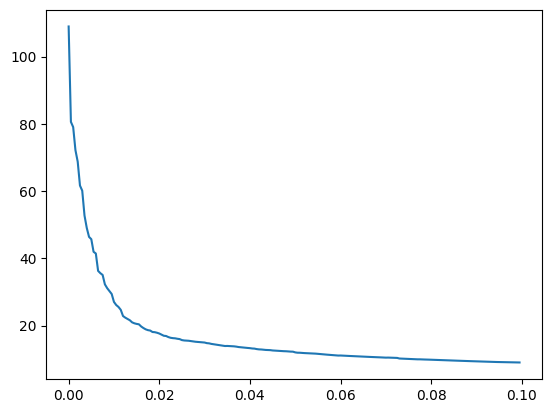

In [19]:
#SOLUTION: 
import random
lengths = []
fractions = []
foundit = False
G = create_circle_network()

for i in range(200):
    fractions.append(i/len(G.edges()))
    edge_to_remove = random.choice(list(G.edges()))
    G.remove_edge(*edge_to_remove)
    
    G.add_edge( edge_to_remove[0],random.randint(0,len(G.nodes)))
    lengths.append(nx.average_shortest_path_length(G))

    if lengths[len(lengths)-1]<12.5 and not foundit:
        print(f"The network became 10 times smaller after replacing {100*fractions[len(fractions)-1]}% of the edges.")
         
        nx.draw_circular(G, with_labels=True, node_color='lightblue', node_size=20, font_size=5)
        plt.title(f"Random Network with {num_nodes} Nodes")
        plt.show()
        foundit=True

        
plt.plot(fractions, lengths)


# 2. Modeling how we make friends

Let's think about different models for how we make friends, and examine the type of social network that this results in.

### Model 1: We meet random people
One is just by meeting people by random. This would suggest just adding edges between two randomly selected nodes until we have as many edges that we want.

This is called an Erdos-Renyi network.

#### Your task: 
1. Write code for a network in which the nodes are connected to other nodes by random.
2. Plot the degree distribution. You have come across this distribution before. What type of distribution is it? 

In [24]:
# Random network
import networkx as nx
from matplotlib import pyplot as plt
import itertools
import numpy as np

# This code creates a network where nodes are 
def create_random_network(num_nodes,num_edges_per_node):
    G = nx.Graph()
    
    #Add the nodes
    for i in range(num_nodes):
        G.add_node(i)

    #SOLUTION:
    for i in range(num_edges_per_node*num_nodes):
        G.add_edge( random.randint(0,num_nodes), random.randint(0,num_nodes) )

    # Draw the network
    nx.draw(G, with_labels=True, node_color='lightblue', node_size=20, font_size=5)
    plt.title(f"Random Network with {num_nodes} Nodes")
    plt.show()
    return G

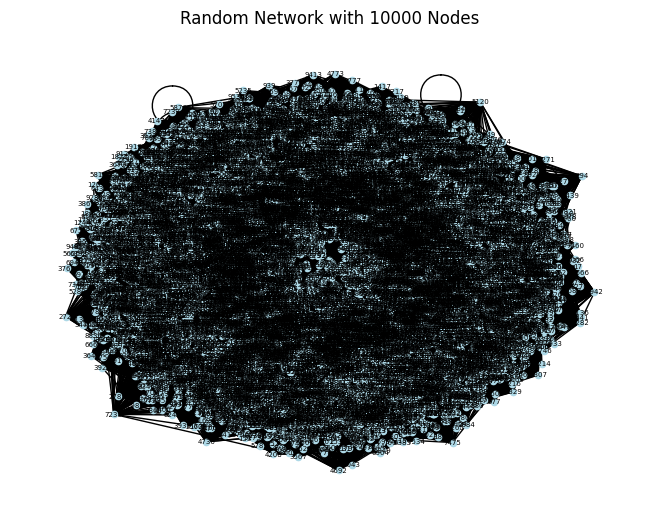

In [25]:
G = create_random_network(10000,50)

Let's plot the degree distribution of this network. To do so, we create a histogram of the frequency of each number of degrees. 

The degree distribution is a highly important measure, as it shows how equal the network is, and how dominated it is by a few nodes.



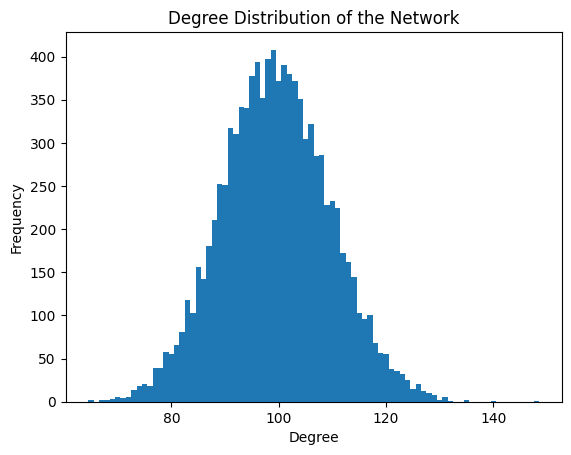

In [27]:
# Plot the degree distribution 

import networkx as nx
import matplotlib.pyplot as plt

def plot_degree_distribution(G):
    # Calculate the degrees of each node
    #SOLUTION:
    degrees = [degree for node, degree in G.degree()]
    
    # Create the histogram of degrees
    plt.hist(degrees, bins=range(min(degrees), max(degrees) + 2), align='left')
    
    # Set labels and title
    plt.xlabel('Degree')
    plt.ylabel('Frequency')
    plt.title('Degree Distribution of the Network')
    
    # Show the plot
    plt.show()
    return degrees
degrees = plot_degree_distribution(G)

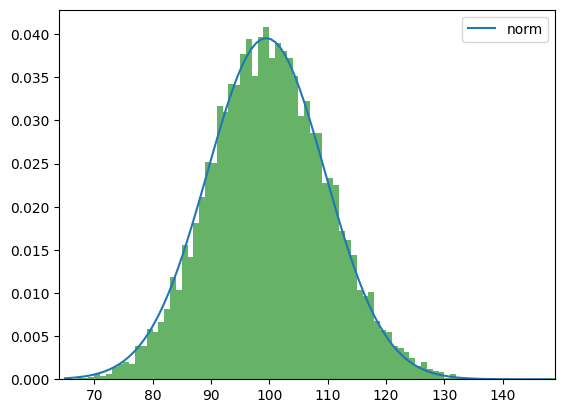

In [28]:
# Solution: we can fit a normal distribution to it.
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Sample data
data = [degree for node, degree in G.degree()]

# Plot histogram of the data
plt.hist(data, bins=range(min(data), max(data) + 2), density=True, alpha=0.6, color='g')

# List of candidate distributions
distributions = [stats.norm] 

# Fit distributions to the data and plot
for distribution in distributions:
    # Fit distribution to data
    params = distribution.fit(data)
    
    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]
    
    # Calculate fitted PDF and error with fit in distribution
    pdf = distribution.pdf(np.linspace(min(data), max(data), 100), loc=loc, scale=scale, *arg)
    plt.plot(np.linspace(min(data), max(data), 100), pdf, label=f"{distribution.name}")
    plt.xlim([min(data) - 1, max(data) + 1])

plt.legend(loc='upper right')
plt.show()

### Model 2: Friends make friends through friends

The network we created, the nodes are connected randomly based on the nodes. But in most real-world networks, you make connections through your existing connections. For instance, the probability that you follow someone on Twitter depends on how many followers the person already has, since you are likely to encounter them through their followers.

These degree distributions are ubiquitous, and characterize nearly all networks around us, including link between websites, flights connecting airports, and so on.

In most social networks, nodes build connections based on their existing connections. This is called "preferential attachment".

#### Your task:
1. You will simulate the growth of a social media network. The network will have N nodes. These join one at the time. At each step, add one new node, then sample M existing nodes based on their edges, and add num_edges_per_node edges to these.
2. Plot the resulting degree distribution. What type of distribution is this? What does it mean that networks have this type of structure?


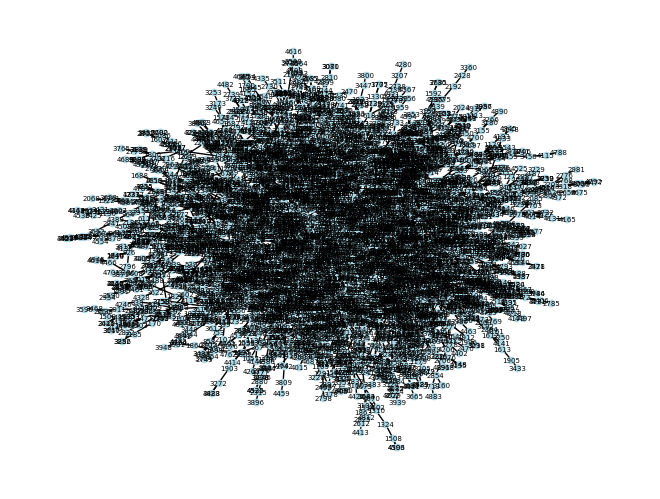

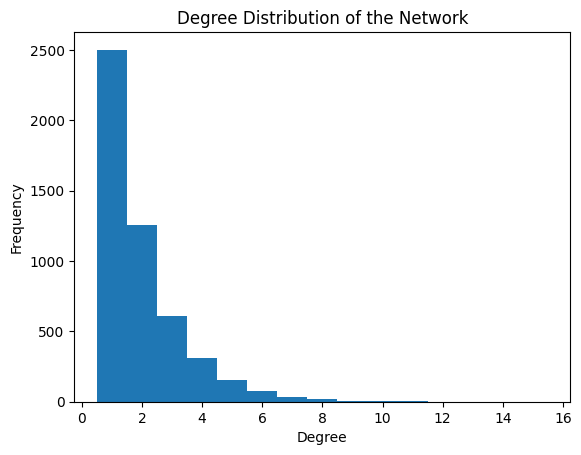

In [39]:
# SOLUTION:

def create_random_network_by_edges(num_nodes,num_edges_per_node):
    G = nx.Graph()
    G.add_node(0)
    G.add_node(1)
    G.add_edge(0,1)
    
    for i in range(2,num_nodes):
        G.add_node(i)
        
        for _ in range(num_edges_per_node):
            random_node_by_edge = random.choice(list(G.edges()))[1] #Get the receiving node!
            G.add_edge( i, random_node_by_edge )
    
    # Draw the network
    nx.draw(G, with_labels=True, node_color='lightblue', node_size=20, font_size=5)
    plt.show()
    return G

G = create_random_network_by_edges(5000,30)
degrees = plot_degree_distribution(G)


(array([5.007e-01, 2.472e-01, 1.268e-01, 6.250e-02, 3.370e-02, 1.420e-02,
        6.800e-03, 4.100e-03, 1.800e-03, 1.200e-03, 4.000e-04, 3.000e-04,
        2.000e-04, 1.000e-04]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15.]),
 <BarContainer object of 14 artists>)

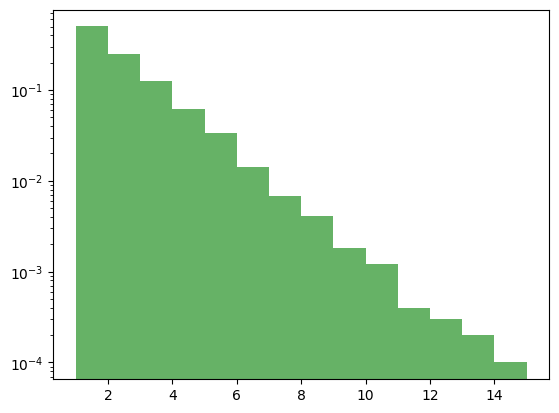

In [36]:
# It's straight on a log! 
plt.hist(data, bins=range(min(data), max(data) + 2), density=True, alpha=0.6, color='g', log=True)

Power law distribution: It's a scale-free network!

# 3. Epidemics in networks 

Networks also allow us to model dynamic phenomena, such as the spread of ideas, habits, or disease through networks. 

The structure of the network is central to how these spread. For instance, if Twitter changes how followingship is made, this will affect the dynamics of virality on Twitter.

The same accounts to disease spread. The SIR model is a classic framework used in epidemiology to understand how diseases spread through populations. SIR stands for Susceptible, Infected, and Recovered, which are the three possible states of individuals in this model:

- Susceptible (S): Individuals who have not yet contracted the disease and are vulnerable to infection.
- Infected (I): Individuals who have contracted the disease and are capable of spreading it to susceptible individuals.
- Recovered (R): Individuals who have recovered from the disease and are no longer susceptible to it. In some models, 'Recovered' can also include individuals who have died from the disease, as they are no longer part of the infection cycle.

We are now going to look at how the spread of the disease depends on the network structure. 

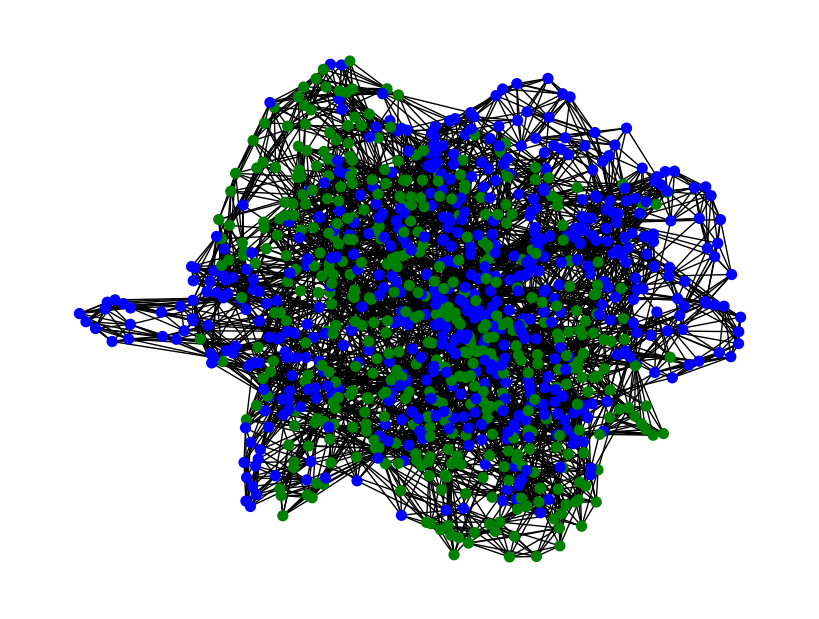

In [14]:
import networkx as nx
import matplotlib.pyplot as plt
import random

def SIR_simulation(G, initial_infected, infection_prob, recovery_prob):
    # Initialize all nodes as susceptible
    nx.set_node_attributes(G, 'S', 'state')

    # Infect initial nodes
    for node in initial_infected:
        G.nodes[node]['state'] = 'I'

    S, I, R = [], [], []
    # for _ in range(steps):
    while(True):
        new_infected = []
        new_recovered = []

        # Spread the infection
        for node in G:
            if G.nodes[node]['state'] == 'I':
                neighbors = list(G.neighbors(node))
                for neighbor in neighbors:
                    if G.nodes[neighbor]['state'] == 'S' and random.random() < infection_prob:
                        new_infected.append(neighbor)

                # Recover process
                if random.random() < recovery_prob:
                    new_recovered.append(node)

        # Update the states
        for node in new_infected:
            G.nodes[node]['state'] = 'I'
        for node in new_recovered:
            G.nodes[node]['state'] = 'R'

        S.append(sum(1 for n in G if G.nodes[n]['state'] == 'S'))
        nr_infected = sum(1 for n in G if G.nodes[n]['state'] == 'I')
        I.append(nr_infected)
        R.append(sum(1 for n in G if G.nodes[n]['state'] == 'R'))
        if nr_infected == 0:
            break

    return S, I, R

def plot_network(G):
    # Colors for nodes
    colors = ['blue' if G.nodes[node]['state'] == 'S' else ('red' if G.nodes[node]['state'] == 'I' else 'green') for node in G]

    plt.figure(figsize=(8, 6))
    nx.draw(G, node_color=colors, node_size=50, with_labels=False)
    plt.show()

# Parameters for the SIR simulation
initial_infected_count = 5
infection_prob = 0.02 
recovery_prob = 0.1

# Create different network types
G = nx.watts_strogatz_graph(1000, 10, 0.1)    

# Example run!
initial_infected = random.sample(list(G.nodes()), initial_infected_count)
S, I, R = SIR_simulation(G, initial_infected, infection_prob, recovery_prob)
plot_network(G)


## Your task

Your task is to compare how well a disease spreads in different network structures. In which network does the disease spread fastest? In which networks does the disease spread to the most nodes?

In [ ]:
# Networks to compare

"Scale-Free Network": nx.barabasi_albert_graph(1000, 2),
"Small-World Network": nx.watts_strogatz_graph(1000, 4, 0.1),
"Random Network": nx.erdos_renyi_graph(1000, 0.05),
"Network with Communities": nx.connected_caveman_graph(10, 100)


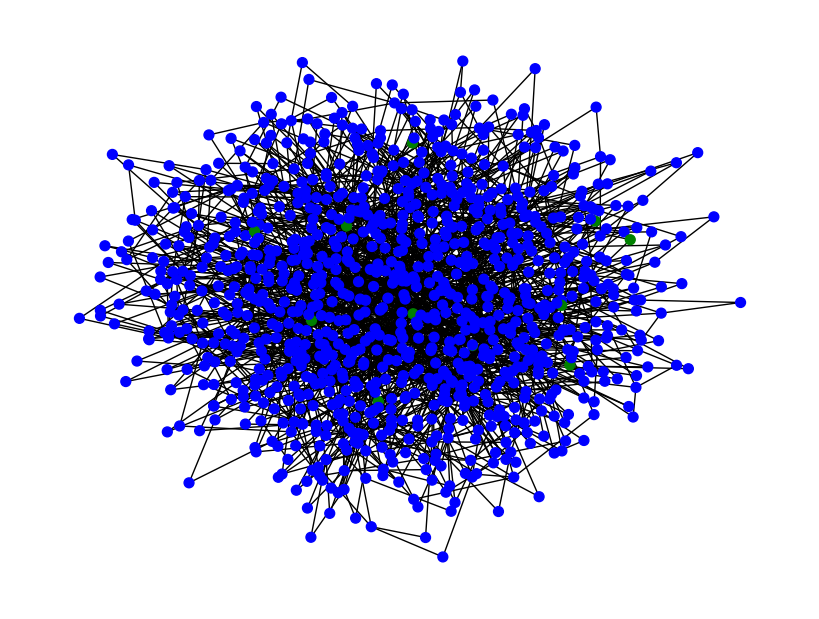

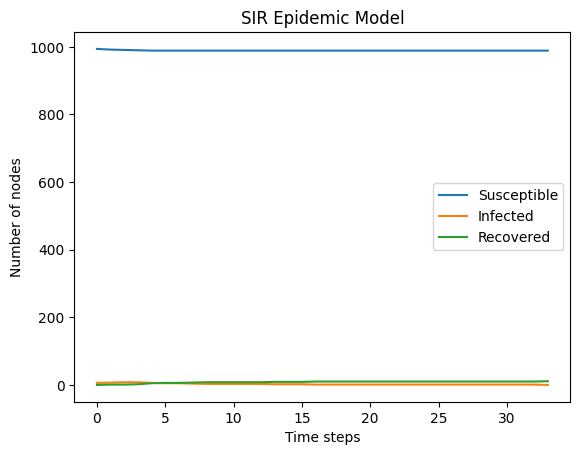

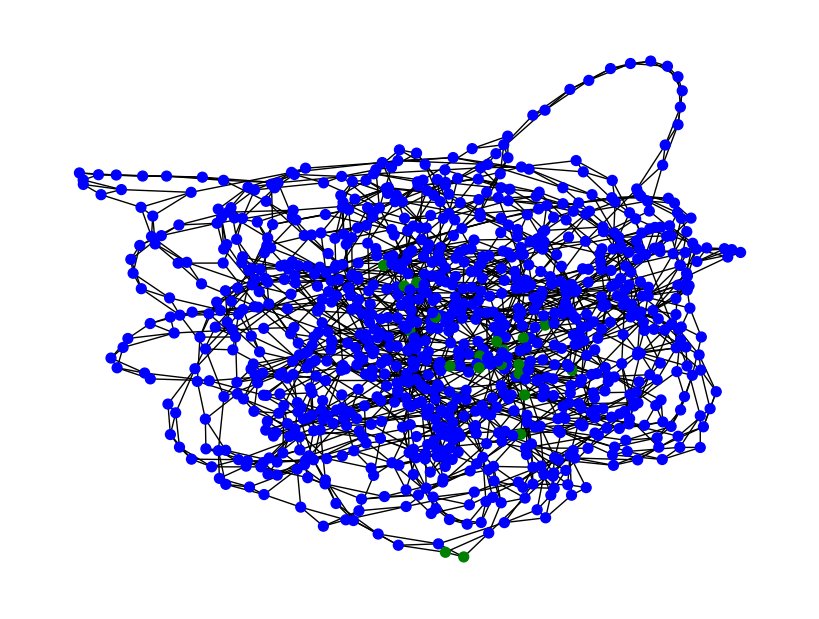

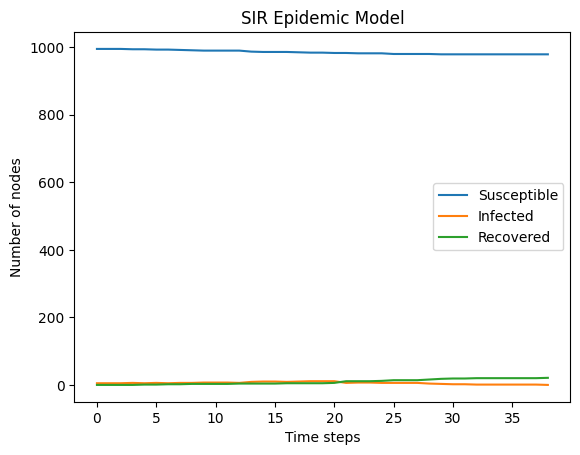

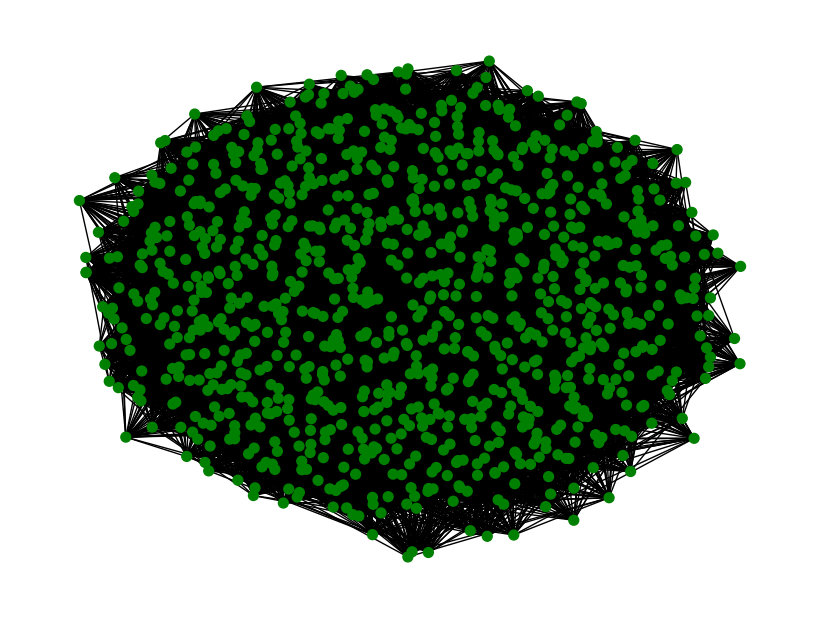

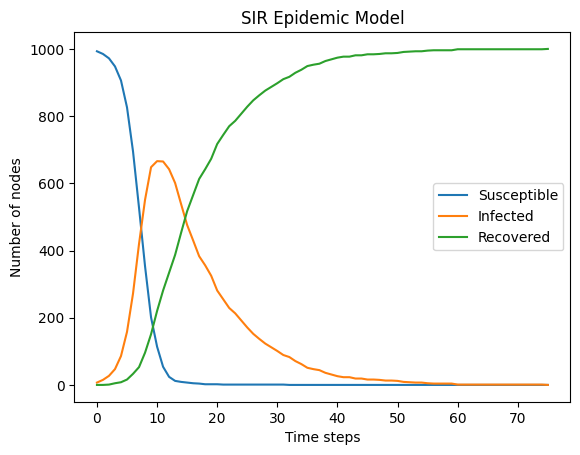

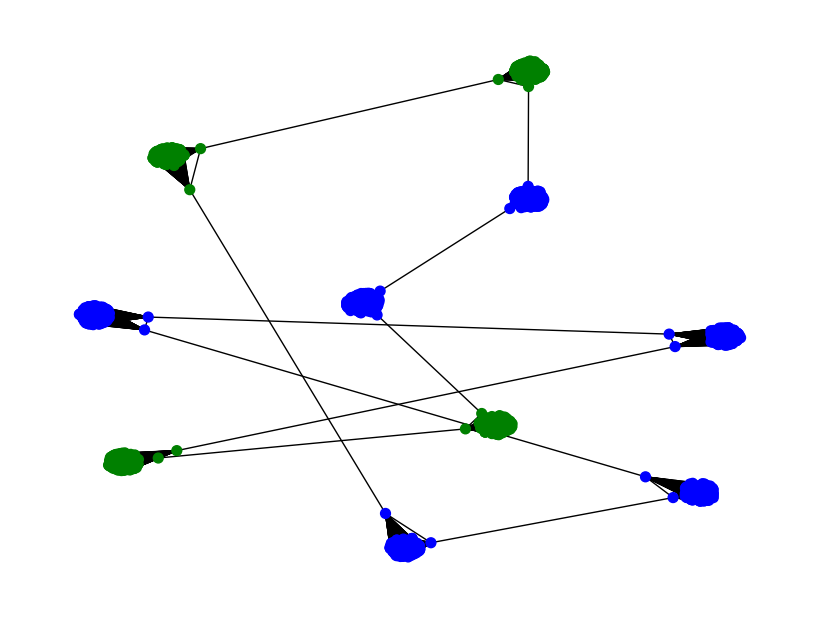

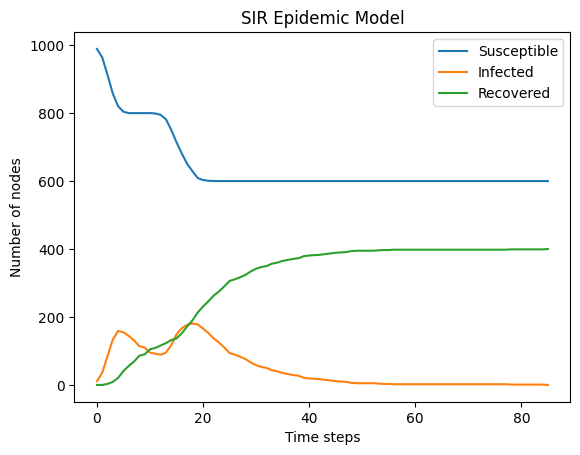

In [17]:
# SOLUTION:

# Create different network types
# Calculate the probability for the Erdős-Rényi graph
num_nodes = 1000
target_edges = 2000
p = 2000 / (num_nodes * (num_nodes - 1) / 2)

# Create the networks
networks = {
"Scale-Free Network": nx.barabasi_albert_graph(1000, 2),
"Small-World Network": nx.watts_strogatz_graph(1000, 4, 0.1),
"Random Network": nx.erdos_renyi_graph(1000, 0.05),
"Network with Communities": nx.connected_caveman_graph(10, 100)
}

# Run the simulation and plot each network
for title, G in networks.items():
    initial_infected = random.sample(list(G.nodes()), initial_infected_count)
    S, I, R = SIR_simulation(G, initial_infected, infection_prob, recovery_prob)
    plot_network(G)
    
    # Plotting
    plt.plot(S, label='Susceptible')
    plt.plot(I, label='Infected')
    plt.plot(R, label='Recovered')
    plt.xlabel('Time steps')
    plt.ylabel('Number of nodes')
    plt.title('SIR Epidemic Model')
    plt.legend()
    plt.show()


# 4. Cascading failures in electricity grids

Cascading failures in electricity grids refer to a process where a failure in one part of the grid triggers a chain of failures throughout the system, leading to a large-scale power outage or blackout. The cascade often begins with a single failure or fault in one component of the grid, such as a transmission line, transformer, or generator. When a component fails, the electrical load it was carrying is redistributed to other parts of the grid. If this redistribution results in an excessive load on these components, they can also fail. Each subsequent failure puts additional strain on the system, causing more components to fail. This can create a domino effect, leading to widespread disconnections and outages.

You are a terrorist and you want to attack the US electricity grid. You have acquired the network of nodes, and you want to find how you can do the most damage.


In [249]:
G = nx.read_gml('./us_powergrid.gml')

In [284]:
#The capacity of the nodes is proportional to their betweenness centrality
pagerank = nx.pagerank(G)
    
# Set node attribute
for node in G.nodes():
    G.nodes[node]['load'] = pagerank[node] * random.uniform(10000, 20000)
    G.nodes[node]['capacity'] = G.nodes[node]['load'] * random.uniform(1.3, 1.6)

In [285]:
nx.write_gexf(G,"us_powergrid.gexf")

In [213]:
G = nx.read_gexf('us_powergrid.gexf')

In [281]:
def initialize_grid():
    # Create a random graph to simulate a grid
    G = nx.read_gexf('us_powergrid.gexf')
    
    return G

# Reset the grid to unfailed status
def reset_grid(G):
    for node in G.nodes:
        G.nodes[node]['current_load'] = G.nodes[node]['load']
        G.nodes[node]['current_capacity'] = G.nodes[node]['capacity']
        G.nodes[node]['failed'] = False

# Fail a particular node
def fail_node(G, neighbors_dict, node):
    # Fail a node and redistribute its load
    load_to_redistribute = G.nodes[node]['current_load']
    G.nodes[node]['current_load'] = 0
    G.nodes[node]['failed'] = True
    neighbors = neighbors_dict[node]
    load_distribution = load_to_redistribute / len(neighbors)
    for neighbor in neighbors:
        G.nodes[neighbor]['current_load'] += load_distribution

# This code cascades the failure througout the network
def cascade_failure(G, neighbors_dict):
    failed = 0
    overloaded = True
    while overloaded:
        overloaded = False
        for node in list(G.nodes):
            if not G.nodes[node]['failed'] and G.nodes[node]['current_load'] > G.nodes[node]['current_capacity']:
                failed += 1
                fail_node(G, neighbors_dict, node)
                overloaded = True
    return failed

#Load graph 
G = initialize_grid()
# Precompute neighbor lists for speed
neighbors_dict = {node: list(G.neighbors(node)) for node in G.nodes}

reset_grid(G)

# Simulate initial failure
initial_failure = random.choice(list(G.nodes))
fail_node(G, neighbors_dict, initial_failure)

# Simulate cascading failure
failed_nodes = cascade_failure(G,neighbors_dict)
print(f"The cascade brought down {failed_nodes} nodes.")


The cascade brought down 2 nodes.


### Your task
Your task is to examine: 

1. What is the distribution of collapses when the node is selected at random?

2. Which node results in the largest cascade? How many nodes are brought down when this is attacked?

In [286]:
# SOLUTION 
# Part 1:
#Load graph 
G = initialize_grid()
# Precompute neighbor lists
neighbors_dict = {node: list(G.neighbors(node)) for node in G.nodes}

outcomes = []
for i in range(50):
    reset_grid(G)
    
    # Simulate initial failure
    initial_failure = random.choice(list(G.nodes))
    fail_node(G, neighbors_dict, initial_failure)
    
    # Simulate cascading failure
    outcomes.append(cascade_failure(G,neighbors_dict))



In [288]:
# SOLUTION 
# Part 2:
#Load graph 
G = initialize_grid()
# Precompute neighbor lists
neighbors_dict = {node: list(G.neighbors(node)) for node in G.nodes}

outcomes = {}
for initial_failure in list(G.nodes):
    reset_grid(G)
    
    # Simulate initial failure
    fail_node(G, neighbors_dict, initial_failure)
    
    # Simulate cascading failure
    outcomes[initial_failure] = cascade_failure(G,neighbors_dict)



In [294]:
sorted_dict = dict(sorted(outcomes.items(), key=lambda item: -item[1]))

print(list(sorted_dict.items())[0])


('2123', 928)


In [299]:
print(f"The mean station leads to {np.mean(list(outcomes.values()))} crashes.")
print(f"The median station leads to {np.median(list(outcomes.values()))} crashes.")
print(f"The max station leads to {max(list(outcomes.values()))} crashes.")

The mean station leads to 12.308237198947582 crashes.
The median station leads to 1.0 crashes.
The max station leads to 928 crashes.
